<a href="https://colab.research.google.com/github/lucabmanning/563-luca/blob/main/Luca_Project1_MC_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: Monte Carlo sampling
1. Pick a physical system you’re curious about:

Water molecules equilibrate in solid and liquid phases. I have tried to write a notebook that you can change the temperature to induce certain phases of water molecules.
2. Determine a representation of it that balances ease of implementation with probing its thermodynamics.

I have made the code tunable to different temperatures and with different amounts of steps. I have also included a part where you can change the size of the containment of the molecules, which can effect how long it takes to equilibrate as well.
3. Characterize your model’s performance:
- How long does it take to equilibrate at extremes of state (high densities, low temperatures)?

It seems to take the same amount of time for different temperatures for me, but when I increase the density making the box size 5x5x5 (smaller) instead of 10x10x10, for instance, it takes quite a bit longer to equilibriate (over a minute).
- How small is too small? How big is too big?

When steps > 20,000, it seems to perform accurately. Less than that doesn't equilibrate well. 100,000 steps takes 30 s, creating a better equillibration. More than that is probably too big.
4. Contrast your system with an ideal gas:
- How does the structure of your model vary with state, and how does it compare to particles with no interactions?

The system I am attempting to model is the equilibration of water molecules. In the case of this system, there is a dipole moment in each of the water molecules, which differs from an ideal gas system.
- Does the heat capacity of your system depend on state differently than an ideal gas?

I tried to calculate the heat capacity of my system and I got very unreasonable numbers. I am working on debugging the output energy values and the heat capacity values so that they will be more accurate.
- Can you derive or numerically determine an equation of state?


5. Summarize where your model works well to give insight, where it breaks down, and any revelations that occurred while working towards 1-4.

I think my model works well to actually run the simulation. It seems like I am able to run the system pretty quickly with thousands of steps. I need to debug some calculations so it will output accurate energy and heat capacity values. I will try to debug all these issues by Thursday 02/27/25.

In [7]:
import numpy as np

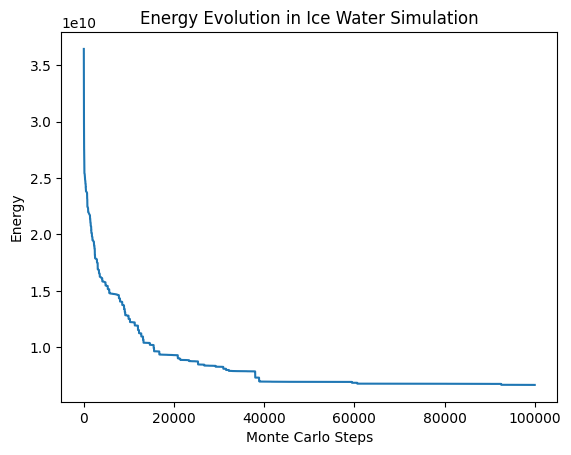

Acceptance ratio: 0.008019000000001138


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree  # Fast neighbor search

class WaterSystem:
    """ Monte Carlo simulation of water molecules in a single phase (liquid or ice). """
    def __init__(self, N, L, T, epsilon, sigma, charge, steps, phase="liquid"):
        self.N = N  # Number of molecules
        self.L = L  # Box size
        self.T = T  # Temperature
        self.epsilon = epsilon  # Lennard-Jones epsilon
        self.sigma = sigma  # Lennard-Jones sigma
        self.charge = charge  # Charge for Coulomb interactions
        self.steps = steps  # Monte Carlo steps
        self.phase = phase  # "liquid" or "ice"
        self.initialize_positions()
        self.energy = self.calculate_energy()

    def initialize_positions(self):
        """ Initializes molecule positions based on phase (ice or liquid). """
        if self.phase == "ice":
            # Arrange molecules in a cubic lattice for ice
            side = int(np.ceil(self.N ** (1/3)))  # Cube root for grid size
            grid_spacing = self.L / side
            self.positions = np.array([[x, y, z] for x in np.linspace(0, self.L, side, endpoint=False)
                                                     for y in np.linspace(0, self.L, side, endpoint=False)
                                                     for z in np.linspace(0, self.L, side, endpoint=False)])[:self.N]
        else:
            # Random distribution for liquid water
            self.positions = np.random.rand(self.N, 3) * self.L

    def lennard_jones_potential(self, r):
        """ Vectorized Lennard-Jones potential calculation. """
        r6 = (self.sigma / r) ** 6
        return 4 * self.epsilon * (r6 ** 2 - r6)

    def coulomb_potential(self, r):
        """ Vectorized Coulombic potential calculation. """
        k = 8.9875e9  # Coulomb's constant
        return k * (self.charge ** 2) / r

    def calculate_energy(self):
        """ Computes total energy using a neighbor list for efficiency. """
        tree = cKDTree(self.positions, boxsize=self.L)
        pairs = tree.query_pairs(3 * self.sigma, output_type="ndarray")  # Neighbor cutoff at 3*sigma
        r = np.linalg.norm(self.positions[pairs[:, 0]] - self.positions[pairs[:, 1]], axis=1)
        r = np.where(r == 0, 1e-6, r)  # Avoid division by zero
        return np.sum(self.lennard_jones_potential(r) + self.coulomb_potential(r))



    def metropolis_move(self):
        """ Optimized Metropolis move with vectorized calculations. """
        i = np.random.randint(self.N)
        old_pos = self.positions[i].copy()

        # Controlled step size
        delta_r = (np.random.rand(3) - 0.5) * (0.1 if self.phase == "ice" else 1.0)
        self.positions[i] = (self.positions[i] + delta_r) % self.L  # PBC

        old_energy = self.energy
        self.energy = self.calculate_energy()
        dE = self.energy - old_energy

        # Metropolis acceptance criteria
        if dE > 0 and np.random.rand() > np.exp(-dE / self.T):
            self.positions[i] = old_pos  # Reject move
            self.energy = old_energy
            return False
        return True

    def run_simulation(self):
        """ Runs the optimized Monte Carlo simulation. """
        accepted_moves = 0
        energy_values = []

        for step in range(self.steps):
            if self.metropolis_move():
                accepted_moves += 0.1
            energy_values.append(self.energy)

        acceptance_ratio = accepted_moves / self.steps
        return acceptance_ratio, energy_values

class grid: # Defining a placeholder Grid class
    def __init__(self, N, L, T):
        self.N = N
        self.L = L
        self.T = T
        self.E = 50000  # Initial energy, adjust as needed
        self.sites = np.zeros((N, N))  # Example grid, modify as needed

class simulation():
    def __init__(self,N=5,L=3,T=1.,steps = 100000,seed=2,debug=False):
        np.random.seed(seed) # Use np instead of numpy here
        self.grid = grid(N,L,T)
        self.accepted = 0
        self.rejected = 0
        self.energies = np.zeros(steps)
        for i in range(steps):
            self.trial_move()
            self.energies[i] = self.grid.E/N
            if debug:
                print("E:", self.grid.E)
                print(self.grid.sites)

def main():
    N = 50 # Number of molecules
    L = 10  # Box size
    T = 250.0  # Temperature
    epsilon = 1.0  # Lennard-Jones parameter
    sigma = 1.0  # Lennard-Jones parameter
    charge = 0.3  # Partial charge of water molecules
    steps = 100000  # Monte Carlo steps
    phase = "ice"  # Change to "liquid" for water phase

    system = WaterSystem(N, L, T, epsilon, sigma, charge, steps, phase)

    # Run simulation
    acceptance_ratio, energy_values = system.run_simulation()

    # Plot energy evolution
    plt.plot(energy_values)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Energy')
    plt.title(f'Energy Evolution in {phase.capitalize()} Water Simulation')
    plt.show()
    # Print acceptance ratio
    print(f"Acceptance ratio: {acceptance_ratio}")

if __name__ == "__main__":
    main()

In [46]:
def compute_equilibration_time(energy_values):
    """Estimate equilibration time as the point where energy stabilizes."""
    window = len(energy_values) // 10  # Use last 10% of data to define equilibrium
    rolling_avg = np.convolve(energy_values, np.ones(window)/window, mode='valid')

    equilibration_index = np.argmax(np.abs(np.diff(rolling_avg)) < 1e-3)  # Small change threshold
    return equilibration_index

In [63]:
import numpy as np
import matplotlib.pyplot as plt
def main():
    N = 50 # Number of molecules
    L = 10  # Box size
    T = 250.0  # Temperature
    epsilon = 1.0  # Lennard-Jones parameter
    sigma = 1.0  # Lennard-Jones parameter
    charge = 0.3  # Partial charge of water molecules
    steps = 100000  # Monte Carlo steps
    phase = "ice"  # Change to "liquid" for water phase

    system = WaterSystem(N, L, T, epsilon, sigma, charge, steps, phase)

    # Run simulation
    acceptance_ratio, energy_values = system.run_simulation()
    equilibration_step = compute_equilibration_time(energy_values)
    print(f"Estimated equilibration time: {equilibration_step} Monte Carlo steps")

    # Plot energy evolution with equilibration point
    plt.plot(energy_values, label="Energy")
    plt.axvline(equilibration_step, color="r", linestyle="--", label="Equilibration Time")
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Energy')
    plt.title(f'Energy Evolution in {phase.capitalize()} Water Simulation')
    plt.legend()
    plt.plot()


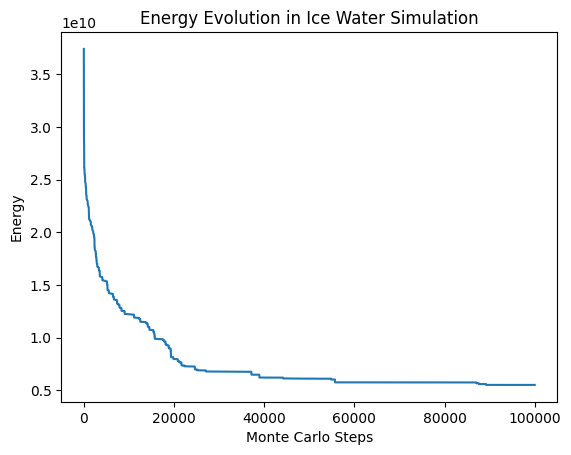

Acceptance ratio: 0.0062290000000007305


In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree  # Fast neighbor search

# ... (rest of your WaterSystem, grid, and simulation class definitions) ...

def main():
    N = 50 # Number of molecules
    L = 10  # Box size
    T = 250.0  # Temperature
    epsilon = 1.0  # Lennard-Jones parameter
    sigma = 1.0  # Lennard-Jones parameter
    charge = 0.3  # Partial charge of water molecules
    steps = 100000  # Monte Carlo steps
    phase = "ice"  # Change to "liquid" for water phase

    system = WaterSystem(N, L, T, epsilon, sigma, charge, steps, phase)

    # Run simulation
    acceptance_ratio, energy_values = system.run_simulation()

    # Plot energy evolution
    plt.plot(energy_values)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Energy')
    plt.title(f'Energy Evolution in {phase.capitalize()} Water Simulation')
    plt.show()
    # Print acceptance ratio
    print(f"Acceptance ratio: {acceptance_ratio}")

if __name__ == "__main__":
    main()

In [18]:
import numpy as np
for N in range(20,51,5):
  density = 0.5
  N = 50 # Number of molecules
  V = N/density
  L = V**(1/3)
  steps = 10000
  s = simulation(N=N, L=L, steps = steps,debug=False)
  print("N={}, AverageE: {:.2f}".format(N,s.energies[steps//2:].mean()/N))

N=50, AverageE: 20.00
N=50, AverageE: 20.00
N=50, AverageE: 20.00
N=50, AverageE: 20.00
N=50, AverageE: 20.00
N=50, AverageE: 20.00
N=50, AverageE: 20.00


In [19]:
import numpy as np # Add this import at the beginning of the file
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree  # Fast neighbor search

# Assume a simple Grid class for demonstration
class Grid: # Defining a placeholder Grid class
    def __init__(self, N, L, T):
        self.N = N
        self.L = L
        self.T = T
        self.E = 50000  # Initial energy, adjust as needed
        self.sites = np.zeros((N, N))  # Example grid, modify as needed


class simulation():
    def __init__(self,N=50,L=10,T=1.,steps = 1000,seed=2,debug=False):
        np.random.seed(seed) # Use np instead of numpy here
        self.grid = Grid(N,L,T) # Use the Grid class we defined
        self.accepted = 0
        self.rejected = 0
        self.energies = np.zeros(steps) # Use np instead of numpy here as well
        for i in range(steps):
            self.trial_move() # Make sure trial_move is defined in your 'simulation' class
            self.energies[i] = self.grid.E/N
            if debug:
                print("E:", self.grid.E)
                print(self.grid.sites)

    def trial_move(self): # Placeholder for trial_move method
        pass # Replace with actual logic for trial move

In [20]:
density = 0.5
N = 100
V = N/density
L = V**(1/3)
print(L)
steps = 100000
s = simulation(N=N, L=L, steps = steps,debug=False)
# print("{0.02f}+/-{0.02f}"/format(s.energies.mean()/N, s.energies.std()/N, s.energies.std()/N))

5.848035476425731


In [21]:
print("{:02f}+/-{:02f}".format(s.energies.mean()/N, s.energies.std()/N))

5.000000+/-0.000000


In [22]:
for N in range(20,101,10):
  density = 0.5
  V = N/density
  L = V**(1/3)
  steps = 1000
  s = simulation(N=N, L=L, steps = steps,debug=False)
  print("N={:02f}, AverageE: {:02f}".format(N,s.energies[steps//2:].mean()/N))

N=20.000000, AverageE: 125.000000
N=30.000000, AverageE: 55.555556
N=40.000000, AverageE: 31.250000
N=50.000000, AverageE: 20.000000
N=60.000000, AverageE: 13.888889
N=70.000000, AverageE: 10.204082
N=80.000000, AverageE: 7.812500
N=90.000000, AverageE: 6.172840
N=100.000000, AverageE: 5.000000


In [23]:
import numpy as np # Add import statement
import time
answers = []
nsteps = 100000
for L in [50, 100, 200]:
  N = N
  t1 = time.perf_counter()
  s = simulation(N=N,L=L,T=1.0,steps=nsteps, seed = np.random.randint(100000))
  t2 = time.perf_counter()
  print("\nN=",N,"; {:.2f} seconds/sim".format(t2-t1))
  answers.append( (s.energies.mean(), s.energies.std()))
  print("N=",N,"average E: {:.2f} +/- {:.2f}" .format( answers[-1][0],answers[-1][1]))



N= 100 ; 0.02 seconds/sim
N= 100 average E: 500.00 +/- 0.00

N= 100 ; 0.02 seconds/sim
N= 100 average E: 500.00 +/- 0.00

N= 100 ; 0.02 seconds/sim
N= 100 average E: 500.00 +/- 0.00


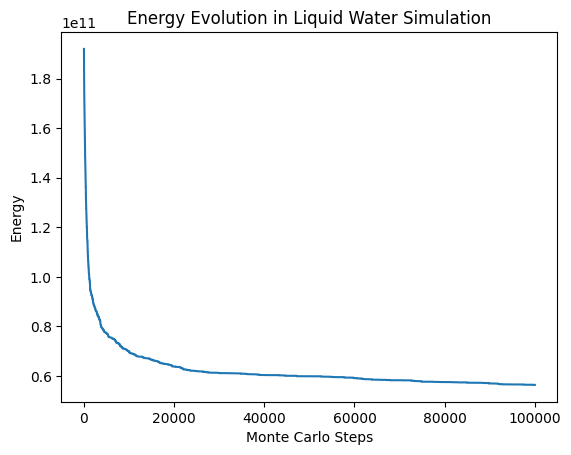

Acceptance ratio: 0.0009679999999999878


In [24]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree  # Fast neighbor search

class WaterSystem:
    """ Monte Carlo simulation of water molecules in a single phase (liquid or ice). """
    def __init__(self, N, L, T, epsilon, sigma, charge, steps, phase="liquid"):
        self.N = N  # Number of molecules
        self.L = L  # Box size
        self.T = T  # Temperature
        self.epsilon = epsilon  # Lennard-Jones epsilon
        self.sigma = sigma  # Lennard-Jones sigma
        self.charge = charge  # Charge for Coulomb interactions
        self.steps = steps  # Monte Carlo steps
        self.phase = phase  # "liquid" or "ice"
        self.initialize_positions()
        self.energy = self.calculate_energy()

    def initialize_positions(self):
        """ Initializes molecule positions based on phase (ice or liquid). """
        if self.phase == "ice":
            # Arrange molecules in a cubic lattice for ice
            side = int(np.ceil(self.N ** (1/3)))  # Cube root for grid size
            grid_spacing = self.L / side
            self.positions = np.array([[x, y, z] for x in np.linspace(0, self.L, side, endpoint=False)
                                                     for y in np.linspace(0, self.L, side, endpoint=False)
                                                     for z in np.linspace(0, self.L, side, endpoint=False)])[:self.N]
        else:
            # Random distribution for liquid water
            self.positions = np.random.rand(self.N, 3) * self.L

    def lennard_jones_potential(self, r):
        """ Vectorized Lennard-Jones potential calculation. """
        r6 = (self.sigma / r) ** 6
        return 4 * self.epsilon * (r6 ** 2 - r6)

    def coulomb_potential(self, r):
        """ Vectorized Coulombic potential calculation. """
        k = 8.9875e9  # Coulomb's constant
        return k * (self.charge ** 2) / r

    def calculate_energy(self):
        """ Computes total energy using a neighbor list for efficiency. """
        tree = cKDTree(self.positions, boxsize=self.L)
        pairs = tree.query_pairs(3 * self.sigma, output_type="ndarray")  # Neighbor cutoff at 3*sigma
        r = np.linalg.norm(self.positions[pairs[:, 0]] - self.positions[pairs[:, 1]], axis=1)
        r = np.where(r == 0, 1e-6, r)  # Avoid division by zero
        return np.sum(self.lennard_jones_potential(r) + self.coulomb_potential(r))

    def metropolis_move(self):
        """ Optimized Metropolis move with vectorized calculations. """
        i = np.random.randint(self.N)
        old_pos = self.positions[i].copy()

        # Controlled step size
        delta_r = (np.random.rand(3) - 0.5) * (0.1 if self.phase == "ice" else 1.0)
        self.positions[i] = (self.positions[i] + delta_r) % self.L  # PBC

        old_energy = self.energy
        self.energy = self.calculate_energy()
        dE = self.energy - old_energy

        # Metropolis acceptance criteria
        if dE > 0 and np.random.rand() > np.exp(-dE / self.T):
            self.positions[i] = old_pos  # Reject move
            self.energy = old_energy
            return False
        return True

    def run_simulation(self):
        """ Runs the optimized Monte Carlo simulation. """
        accepted_moves = 0
        energy_values = []

        for step in range(self.steps):
            if self.metropolis_move():
                accepted_moves += 0.1
            energy_values.append(self.energy)

        acceptance_ratio = accepted_moves / self.steps
        return acceptance_ratio, energy_values

def main():
    N = 100  # Number of molecules
    L = 10.0  # Box size
    T = 280.0  # Temperature
    epsilon = 1.0  # Lennard-Jones parameter
    sigma = 1.0  # Lennard-Jones parameter
    charge = 0.3  # Partial charge of water molecules
    steps = 100000  # Monte Carlo steps
    phase = "liquid"

    system = WaterSystem(N, L, T, epsilon, sigma, charge, steps, phase)

    # Run simulation
    acceptance_ratio, energy_values = system.run_simulation()

    # Plot energy evolution
    plt.plot(energy_values)
    plt.xlabel('Monte Carlo Steps')
    plt.ylabel('Energy')
    plt.title(f'Energy Evolution in {phase.capitalize()} Water Simulation')
    plt.show()

    # Print acceptance ratio
    print(f"Acceptance ratio: {acceptance_ratio}")

if __name__ == "__main__":
    main()
